This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784

# latent distribution is a 2-dimensional Gaussian
# just for convenience (plotting)
latent_dim = 2 

intermediate_dim = 256
epochs = 1
epsilon_std = 1.0


First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma.

In [3]:
x = Input(batch_shape=(batch_size, original_dim)) 
h = Dense(intermediate_dim, activation='relu')(x) 
z_mean = Dense(latent_dim)(h)                     
z_log_var = Dense(latent_dim)(h)                  

In [4]:
x.shape, h.shape, z_mean.shape

(TensorShape([Dimension(100), Dimension(784)]),
 TensorShape([Dimension(100), Dimension(256)]),
 TensorShape([Dimension(100), Dimension(2)]))

Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. 

In [5]:
# latent mean and variance are parts of the network, while generated random variables are "extraneous" things
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#Wraps arbitrary expression as a `Layer` object.

# Examples
# add a x -> x^2 layer
# model.add(Lambda(lambda x: x ** 2))

z = Lambda(sampling)([z_mean, z_log_var])
z.shape

TensorShape([Dimension(100), Dimension(2)])

Finally, a decoder network maps these latent space points back to the original input data.

In [6]:
# we instantiate these layers separately so as to reuse them later

decoder_h = Dense(intermediate_dim, activation='relu')  
h_decoded = decoder_h(z)

decoder_mean = Dense(original_dim, activation='sigmoid') 
x_decoded_mean = decoder_mean(h_decoded)

h_decoded.shape, x_decoded_mean.shape

(TensorShape([Dimension(100), Dimension(256)]),
 TensorShape([Dimension(100), Dimension(784)]))

In [7]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x



In [8]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514         dense_1[0][0]                    
___________________________________________________________________________________________

In [10]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 23s - loss: 191.6938 - val_loss: 174.5666


In [12]:
vae.save("test_save.h5")

In [13]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_2 (Dense)              (100, 2)                  514       
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


In [15]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded.shape

(10000, 2)

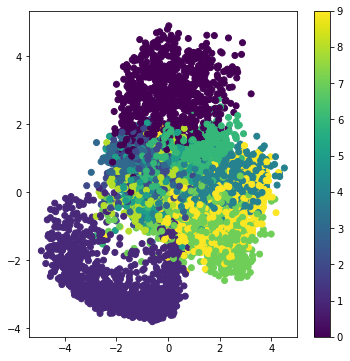

In [16]:

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [17]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
decoder_input.shape

TensorShape([Dimension(None), Dimension(2)])

In [18]:
_h_decoded = decoder_h(decoder_input)
_h_decoded.shape

TensorShape([Dimension(None), Dimension(256)])

In [19]:
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [20]:
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              multiple                  768       
_________________________________________________________________
dense_5 (Dense)              multiple                  201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [26]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_x

array([ -1.64485363e+00,  -1.20404696e+00,  -9.20822976e-01,
        -6.97141435e-01,  -5.03965367e-01,  -3.28072108e-01,
        -1.61844167e-01,  -1.39145821e-16,   1.61844167e-01,
         3.28072108e-01,   5.03965367e-01,   6.97141435e-01,
         9.20822976e-01,   1.20404696e+00,   1.64485363e+00])

In [30]:
norm.ppf(np.array([0.005,0.25,0.5,0.75, 0.995]))

array([-2.5758293 , -0.67448975,  0.        ,  0.67448975,  2.5758293 ])

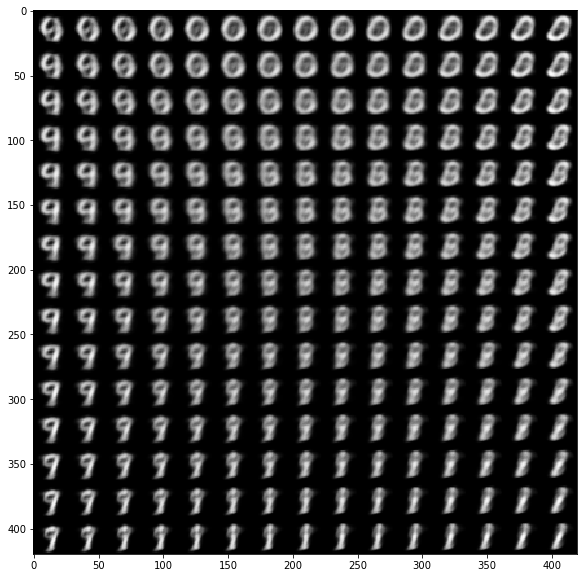

In [33]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # predict for a grid of means
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
